**Notebook credit**: Based on the original D2L notebook [here](https://github.com/d2l-ai/d2l-en-colab/blob/master/chapter_convolutional-neural-networks/conv-layer.ipynb).


# Convolutions for Images


Now that we understand how convolutional layers work in theory,
we are ready to see how they work in practice.
Building on our motivation of convolutional neural networks
as efficient architectures for exploring structure in image data,
we stick with images as our running example.




## The Cross-Correlation Operation

Recall that strictly speaking, convolutional layers
are a  misnomer, since the operations they express
are more accurately described as cross-correlations.
Based on our descriptions of convolutional layers,
in such a layer, an input tensor
and a kernel tensor are combined
to produce an output tensor through a (**cross-correlation operation.**)

Let us ignore channels for now and see how this works
with two-dimensional data and hidden representations.
In the figure below,
the input is a two-dimensional tensor
with a height of 3 and width of 3.
We mark the shape of the tensor as $3 \times 3$ or ($3$, $3$).
The height and width of the kernel are both 2.
The shape of the *kernel window* (or *convolution window*)
is given by the height and width of the kernel
(here it is $2 \times 2$).

![Two-dimensional cross-correlation operation. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times0+1\times1+3\times2+4\times3=19$.](http://d2l.ai/_images/correlation.svg)


In the two-dimensional cross-correlation operation,
we begin with the convolution window positioned
at the upper-left corner of the input tensor
and slide it across the input tensor,
both from left to right and top to bottom.
When the convolution window slides to a certain position,
the input subtensor contained in that window
and the kernel tensor are multiplied elementwise
and the resulting tensor is summed up
yielding a single scalar value.
This result gives the value of the output tensor
at the corresponding location.
Here, the output tensor has a height of 2 and width of 2
and the four elements are derived from
the two-dimensional cross-correlation operation:

$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.
$$

Note that along each axis, the output size
is slightly smaller than the input size.
Because the kernel has width and height greater than one,
we can only properly compute the cross-correlation
for locations where the kernel fits wholly within the image,
the output size is given by the input size $n_h \times n_w$
minus the size of the convolution kernel $k_h \times k_w$
via

$$(n_h-k_h+1) \times (n_w-k_w+1).$$

This is the case since we need enough space
to "shift" the convolution kernel across the image.
Later we will see how to keep the size unchanged
by padding the image with zeros around its boundary
so that there is enough space to shift the kernel.
Next, we implement this process in the `corr2d` function,
which accepts an input tensor `X` and a kernel tensor `K`
and returns an output tensor `Y`.


In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
def corr2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = tf.Variable(tf.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1)))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j].assign(tf.reduce_sum(
                X[i: i + h, j: j + w] * K))
    return Y

We can construct the input tensor `X` and the kernel tensor `K`
from the figure above
to **validate the output of the above implementation**
of the two-dimensional cross-correlation operation.


In [ ]:
X = tf.constant([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = tf.constant([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K).numpy()

array([[19., 25.],
       [37., 43.]], dtype=float32)

## Convolutional Layers

A convolutional layer cross-correlates the input and kernel
and adds a scalar bias to produce an output.
The two parameters of a convolutional layer
are the kernel and the scalar bias.
When training models based on convolutional layers,
we typically initialize the kernels randomly,
just as we would with a fully-connected layer.

We are now ready to **implement a two-dimensional convolutional layer**
based on the `corr2d` function defined above.
In the `build()` method,
we set `weight` and `bias` as the two model parameters.
The `call()` method
calls the `corr2d` function and adds the bias.


In [ ]:
class Conv2D(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, kernel_size):
        initializer = tf.random_normal_initializer()
        self.weight = self.add_weight(name='w', shape=kernel_size,
                                      initializer=initializer)
        self.bias = self.add_weight(name='b', shape=(1, ),
                                    initializer=initializer)

    def call(self, inputs):
        return corr2d(inputs, self.weight) + self.bias

In
$h \times w$ convolution
or a $h \times w$ convolution kernel,
the height and width of the convolution kernel are $h$ and $w$, respectively.
We also refer to
a convolutional layer with a $h \times w$
convolution kernel simply as a $h \times w$ convolutional layer.


## Object Edge Detection in Images

Let us take a moment to parse [**a simple application of a convolutional layer:
detecting the edge of an object in an image**]
by finding the location of the pixel change.
First, we construct an "image" of $6\times 8$ pixels.
The middle four columns are black (0) and the rest are white (1).


In [ ]:
X = tf.Variable(tf.ones((6, 8)))
X[:, 2:6].assign(tf.zeros(X[:, 2:6].shape))
X.numpy()

array([[1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.]], dtype=float32)

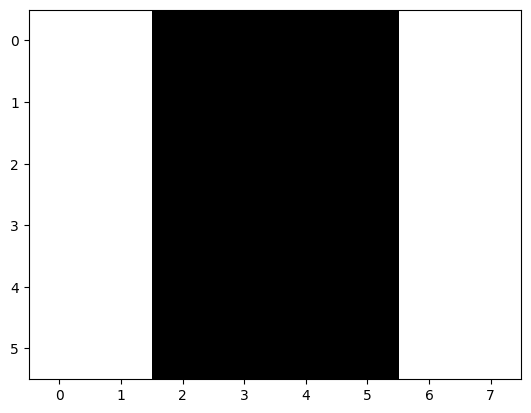

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(tf.reshape(X, (6, 8)), cmap="gray")
plt.show()

Next, we construct a kernel `K` with a height of 1 and a width of 2.
When we perform the cross-correlation operation with the input,
if the horizontally adjacent elements are the same,
the output is 0. Otherwise, the output is non-zero.


In [ ]:
K = tf.constant([[1.0, -1.0]])

We are ready to perform the cross-correlation operation
with arguments `X` (our input) and `K` (our kernel).
As you can see, **we detect 1 for the edge from white to black
and -1 for the edge from black to white.**
All other outputs take value 0.


In [ ]:
Y = corr2d(X, K)
Y.numpy()

array([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.]], dtype=float32)

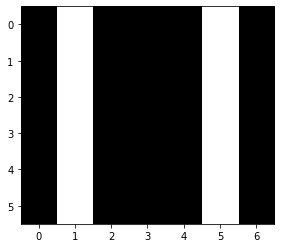

In [ ]:
plt.imshow(tf.reshape(tf.abs(Y), (6, 7)), cmap = "gray")
plt.show()

We can now apply the kernel to the transposed image.
As expected, it vanishes. **The kernel `K` only detects vertical edges.**


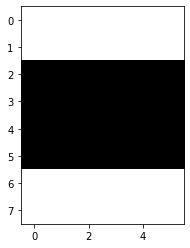

In [ ]:
plt.imshow(tf.reshape(tf.transpose(X), (8, 6)), cmap="gray")
plt.show()

In [ ]:
Y2 = corr2d(tf.transpose(X), K)
Y2.numpy()

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

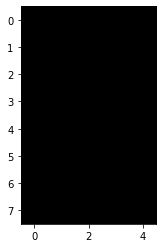

In [ ]:
plt.imshow(tf.reshape(tf.abs(Y2), (8, 5)), cmap = "gray")
plt.show()

## Learning a Kernel

Designing an edge detector by finite differences `[1, -1]` is neat
if we know this is precisely what we are looking for.
However, as we look at larger kernels,
and consider successive layers of convolutions,
it might be impossible to specify
precisely what each filter should be doing manually.

Now let us see whether we can **learn the kernel that generated `Y` from `X`**
by looking at the input--output pairs only.
We first construct a convolutional layer
and initialize its kernel as a random tensor.
Next, in each iteration, we will use the squared error
to compare `Y` with the output of the convolutional layer.
We can then calculate the gradient to update the kernel.
For the sake of simplicity,
in the following
we use the built-in class
for two-dimensional convolutional layers
and ignore the bias.


In [ ]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = tf.keras.layers.Conv2D(1, (1, 2), use_bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, height, width, channel), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = tf.reshape(X, (1, 6, 8, 1))
Y = tf.reshape(Y, (1, 6, 7, 1))
lr = 2e-2  # Learning rate

Y_hat = conv2d(X)
for i in range(10):
    with tf.GradientTape() as tape:
        Y_hat = conv2d(X)
        loss = tf.reduce_sum(tf.abs(Y_hat - Y) ** 2)
        # Update the kernel
        loss_gradient = tape.gradient(loss, conv2d.weights[0])
        update = tf.multiply(lr, loss_gradient)
        weights = conv2d.get_weights()
        weights[0] = conv2d.weights[0] - update
        conv2d.set_weights(weights)
        if (i + 1) % 2 == 0:
            print(f'epoch {i + 1}, loss {loss:.3f}')

epoch 2, loss 7.194
epoch 4, loss 2.360
epoch 6, loss 0.787
epoch 8, loss 0.263
epoch 10, loss 0.088


Note that the error has dropped to a small value after 10 iterations. Now we will **take a look at the kernel tensor we learned.**


In [ ]:
tf.reshape(conv2d.get_weights()[0], (1, 2)).numpy()

array([[ 0.9350534, -0.9350534]], dtype=float32)

Indeed, the learned kernel tensor is remarkably close
to the kernel tensor `K` we defined earlier.



## Cross-Correlation and Convolution

Recall our earlier observation of the correspondence
between the cross-correlation and convolution operations.
Here let us continue to consider two-dimensional convolutional layers.
What if such layers
perform strict convolution operations
instead of cross-correlations?
In order to obtain the output of the strict *convolution* operation, we only need to flip the two-dimensional kernel tensor both horizontally and vertically, and then perform the *cross-correlation* operation with the input tensor.

It is noteworthy that since kernels are learned from data in deep learning,
the outputs of convolutional layers remain unaffected
no matter such layers
perform
either the strict convolution operations
or the cross-correlation operations.

To illustrate this, suppose that a convolutional layer performs *cross-correlation* and learns the kernel in the first figure above, which is denoted as the matrix $\mathbf{K}$ here.
Assuming that other conditions remain unchanged,
when this layer performs strict *convolution* instead,
the learned kernel $\mathbf{K}'$ will be the same as $\mathbf{K}$
after $\mathbf{K}'$ is
flipped both horizontally and vertically.
That is to say,
when the convolutional layer
performs strict *convolution*
for the input in the figure
and $\mathbf{K}'$,
the same output in the figure
(cross-correlation of the input and $\mathbf{K}$)
will be obtained.

In keeping with standard terminology with deep learning literature,
we will continue to refer to the cross-correlation operation
as a convolution even though, strictly-speaking, it is slightly different.
Besides,
we use the term *element* to refer to
an entry (or component) of any tensor representing a layer representation or a convolution kernel.




## Feature Map and Receptive Field

![Two-dimensional cross-correlation operation. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times0+1\times1+3\times2+4\times3=19$.](http://d2l.ai/_images/correlation.svg)

The convolutional layer output in
the figure above
is sometimes called a *feature map*,
as it can be regarded as
the learned representations (features)
in the spatial dimensions (e.g., width and height)
to the subsequent layer.
In CNNs,
for any element $x$ of some layer,
its *receptive field* refers to
all the elements (from all the previous layers)
that may affect the calculation of $x$
during the forward propagation.
Note that the receptive field
may be larger than the actual size of the input.

Let us continue to use the figure above to explain the receptive field.
Given the $2 \times 2$ convolution kernel,
the receptive field of the shaded output element (of value $19$)
is
the four elements in the shaded portion of the input.
Now let us denote the $2 \times 2$
output as $\mathbf{Y}$
and consider a deeper CNN
with an additional $2 \times 2$ convolutional layer that takes $\mathbf{Y}$
as its input, outputting
a single element $z$.
In this case,
the receptive field of $z$
on $\mathbf{Y}$ includes all the four elements of $\mathbf{Y}$,
while
the receptive field
on the input includes all the nine input elements.
Thus,
when any element in a feature map
needs a larger receptive field
to detect input features over a broader area,
we can build a deeper network.






## Summary

* The core computation of a two-dimensional convolutional layer is a two-dimensional cross-correlation operation. In its simplest form, this performs a cross-correlation operation on the two-dimensional input data and the kernel, and then adds a bias.
* We can design a kernel to detect edges in images.
* We can learn the kernel's parameters from data.
* With kernels learned from data, the outputs of convolutional layers remain unaffected regardless of such layers' performed operations (either strict convolution or cross-correlation).
* When any element in a feature map needs a larger receptive field to detect broader features on the input, a deeper network can be considered.


